                          signal
Datetime                        
2023-06-14 09:34:00-04:00   SELL
2023-06-14 09:35:00-04:00   SELL
2023-06-14 09:36:00-04:00    BUY
2023-06-14 09:37:00-04:00    BUY
2023-06-14 09:38:00-04:00   SELL
...                          ...
2023-06-14 15:55:00-04:00   SELL
2023-06-14 15:56:00-04:00   SELL
2023-06-14 15:57:00-04:00   SELL
2023-06-14 15:58:00-04:00   SELL
2023-06-14 15:59:00-04:00   SELL

[386 rows x 1 columns]


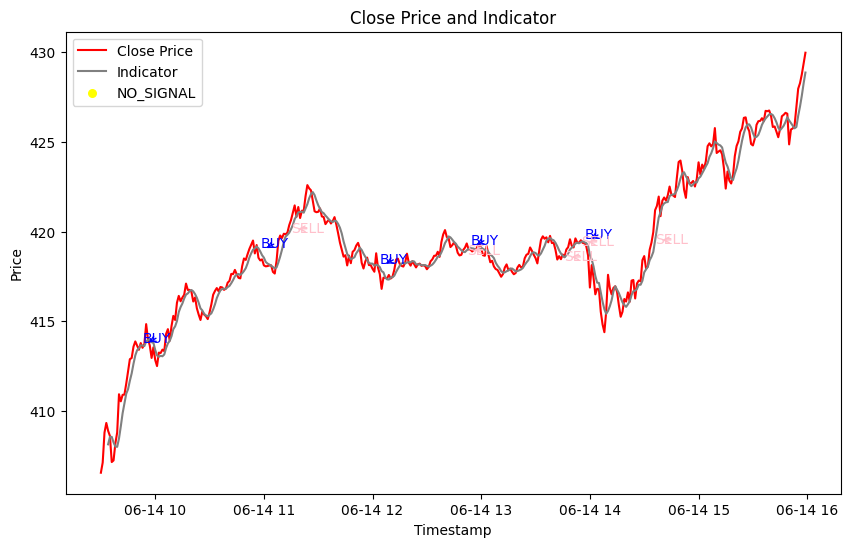

In [6]:
# Generating Signals and Visualizing Close Price with Indicator

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import random

class ScriptData:
    def __init__(self, api_key):
        self.api_key = api_key

    def fetch_intraday_data(self, symbol):
        data = yf.download(symbol, period='1d', interval='1m', progress=False)
        return data

    def convert_intraday_data(self, symbol):
        data = self.fetch_intraday_data(symbol)
        df = pd.DataFrame(data).rename(columns={'Close': 'close', 'Volume': 'volume'})
        df['timestamp'] = df.index
        df = df[['timestamp', 'close', 'volume']]
        return df

class Strategy:
    def __init__(self, api_key):
        self.api_key = api_key
        self.data_obj = ScriptData(self.api_key)

    def indicator1(self, df, timeperiod):
        indicator_df = pd.DataFrame()
        indicator_df['timestamp'] = df['timestamp']
        indicator_df['indicator'] = df['close'].rolling(window=timeperiod).mean()
        indicator_df = indicator_df.dropna()  
        return indicator_df

    def generate_signals(self, symbol, timeperiod):
        df = self.data_obj.convert_intraday_data(symbol)
        close_data = df['close']
        indicator_data = self.indicator1(df, timeperiod)['indicator']

        
        indicator_data_aligned = indicator_data.dropna()
        close_data_aligned = close_data.iloc[-len(indicator_data_aligned):]

       
        signals = pd.DataFrame(index=close_data_aligned.index)
        signals['signal'] = 'NO_SIGNAL'
        signals.loc[indicator_data_aligned > close_data_aligned, 'signal'] = 'BUY'
        signals.loc[indicator_data_aligned < close_data_aligned, 'signal'] = 'SELL'

        return signals, close_data, indicator_data
    
# Define ScriptData and Strategy classes
api_key = "9ADF7OAQPCHJTGBR"
symbol = "NVDA"
timeperiod = 5

# Create an instance of the Strategy class
strategy = Strategy(api_key)
signals, close_data, indicator_data = strategy.generate_signals(symbol, timeperiod)

# Filter the signals for 'BUY' and 'SELL' only
filtered_signals = signals[signals['signal'].isin(['BUY', 'SELL'])]
print(filtered_signals)


# Plot close price and indicator
plt.figure(figsize=(10, 6))
plt.plot(close_data.index, close_data, color='red', label='Close Price')
plt.plot(indicator_data.index, indicator_data, color='grey', label='Indicator')

# Annotate buy signals
buy_signals = filtered_signals[filtered_signals['signal'] == 'BUY'].index.tolist()
random.shuffle(buy_signals)
for buy_signal in buy_signals[:5]:  
    plt.annotate('BUY', xy=(buy_signal, indicator_data.loc[buy_signal]), xytext=(buy_signal, indicator_data.loc[buy_signal] + 0.2),
                 arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle='->', shrinkA=0.5, shrinkB=5), color='blue')

# Annotate sell signals
sell_signals = filtered_signals[filtered_signals['signal'] == 'SELL'].index.tolist()
random.shuffle(sell_signals)
for sell_signal in sell_signals[:5]:  
    plt.annotate('SELL', xy=(sell_signal, indicator_data.loc[sell_signal]), xytext=(sell_signal, indicator_data.loc[sell_signal] - 0.2),
                 arrowprops=dict(facecolor='pink', edgecolor='pink', arrowstyle='->', shrinkA=0.5, shrinkB=5), color='pink')

# Scatter plot for 'NO_SIGNAL' points
no_signal_indices = signals[signals['signal'] == 'NO_SIGNAL'].sample(n=min(5, len(signals[signals['signal'] == 'NO_SIGNAL'])), random_state=42).index
plt.scatter(no_signal_indices, indicator_data.loc[no_signal_indices], c='yellow', marker='o', s=30, label='NO_SIGNAL')

# Plot formatting and display
plt.legend()
plt.title('Close Price and Indicator')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.show()
